In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import time
import os

# For PCA and clustering
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import *

from sklearn.feature_extraction.text import CountVectorizer

import sys
sys.path.append('./data_prep/')

%load_ext autoreload
%autoreload 2
from preprocess_utils import PROCESSED_DATA_DIR, EMBEDDINGS_DIR

import openai
openai.api_key = os.environ['OPENAI_API_KEY']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def sample_cluster_texts(df, cluster_col, cluster, n_papers=25, random_seed=0, titles_only=False):
    np.random.seed(random_seed)
    idxs = np.random.choice(df[df[cluster_col] == cluster].index, size=n_papers, replace=False)
    if titles_only:
        titles_with_abstracts = [f"{df.loc[idx]['title']}" for idx in idxs]
    else:
        titles_with_abstracts = [f"{df.loc[idx]['title']}\n\n{df.loc[idx]['abstract']}" for idx in idxs]
    return '\n\n'.join(titles_with_abstracts)

## Cluster the papers into topics

This step requires embeddings to have already been generated, which you can generate with the ''generate_paper_embeddings.py'' script.

### All cs/stat papers

#### Cluster papers

In [34]:
embeddings_npz = np.load(os.path.join(EMBEDDINGS_DIR, 'abstract-418K-20230916.npz'), allow_pickle=True)
embeddings, ids = embeddings_npz['embeddings'], embeddings_npz['id']

print(embeddings.shape, ids.shape)

metadata = pd.read_json(os.path.join(PROCESSED_DATA_DIR, 'cs_stat_metadata.json'), orient='records', lines=True,
                        dtype={'id': str})
metadata_with_clusters = metadata.set_index('id').loc[ids].reset_index().copy()

(418216, 768) (418216,)


In [36]:
n_components = 200

pca = PCA(n_components=n_components)
pca.fit(embeddings)
emb_pca = pca.transform(embeddings)

In [37]:
import umap

umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(emb_pca)

/share/pierson/conda_virtualenvs/rm868_conda_envs/llm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/share/pierson/conda_virtualenvs/rm868_conda_envs/llm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


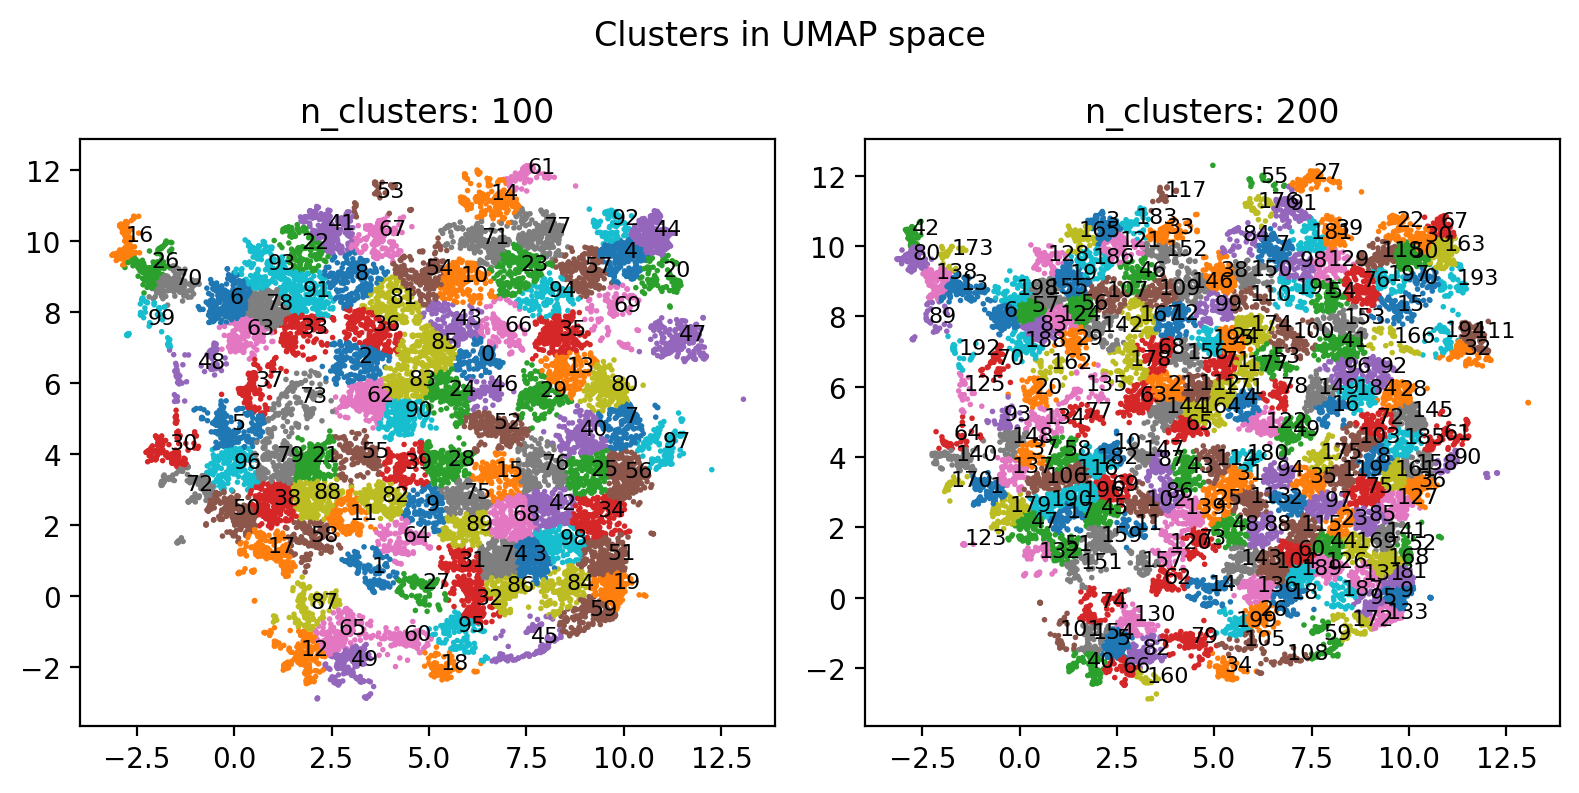

In [42]:
# n_clusters = 100
n_cluster_values = [100, 200]

# plt.figure(figsize=(4, 4), dpi=200)
f, axs = plt.subplots(1, len(n_cluster_values), figsize=(4*len(n_cluster_values), 4), dpi=200)

clusterings = {}
for (i, n_clusters) in enumerate(n_cluster_values):
    ax = axs[i]

    # Cluster the UMAP embeddings using K-means clustering
    kmeans_umap = KMeans(n_clusters=n_clusters, random_state=0).fit(umap_emb)
    clusterings[n_clusters] = kmeans_umap.labels_

    # Visualize the clusters in 2D
    if len(umap_emb) > 20000:
        random_idxs = np.random.choice(len(umap_emb), size=20000, replace=False)
        ax.scatter(umap_emb[random_idxs,0], umap_emb[random_idxs,1], c=kmeans_umap.labels_[random_idxs], cmap='tab10', s=1)
    else:
        ax.scatter(umap_emb[:,0], umap_emb[:,1], c=kmeans_umap.labels_, cmap='tab10', s=1)
        
    ax.set_title(f'n_clusters: {n_clusters}')

    # Add small annotations of cluster numbers near the points
    for j in range(n_clusters):
        cluster_centers = np.mean(umap_emb[kmeans_umap.labels_ == j], axis=0)
        ax.text(cluster_centers[0], cluster_centers[1], str(j), fontsize=8)

plt.suptitle('Clusters in UMAP space')
plt.tight_layout()
plt.show()

In [43]:
metadata_with_clusters['cluster'] = clusterings[100]

#### Use GPT-4 to name the clusters

In [46]:
import json

cluster_count = 100
n_trials_per_cluster = 2
cluster_col = 'cluster'
n_papers = 15

initialization = """
You are a researcher in Computer Science that is trying to understand the main research directions of published CS papers.
"""

prompt = """
I will provide the titles and abstracts for a cluster of Computer Science papers. 
You will provide a short title summarizing the entire set, using less than or equal to 4 words.
Be as specific as possible, while still accurately describing most papers in the cluster.
Do not use general words like "advance", "improve", or "enhance", or any forms of these words.
Do not say "Computer Science", since this is already implied.
"""

t0 = time.time()
fp = os.path.join(PROCESSED_DATA_DIR, 'cluster_names', f'GPT4-cs-stat-cluster-names-n{cluster_count}.txt')
cluster_names = {i : [] for i in range(cluster_count)}

for i in range(cluster_count):
    print(f'Cluster {i}')
    for trial in range(n_trials_per_cluster):
        response = openai.ChatCompletion.create(
            model='gpt-4',
            messages=[
                {'role': 'system', 'content': initialization},
                {'role': 'user', 'content': prompt},
                # {'role': 'user', 'content': 'Example: \n\n Input: \n\n' + sample_cluster_texts(metadata_with_clusters, cluster_col, cluster=0, n_papers=10) + 'Output: \n\n'},
                # {'role': 'assistant', 'content': 'Bias & Social Applications'},
                {'role': 'user', 'content': 'Input:\n\n' + sample_cluster_texts(metadata_with_clusters, cluster_col, i, n_papers=n_papers, random_seed=trial) + 'Output:\n\n'},
            ],
            temperature=0.5,
        )
        cluster_name = response['choices'][0]['message']['content'].strip()
        print(cluster_name)
        cluster_names[i].append(cluster_name)
    print()
    # Sleep to avoid rate limit
    time.sleep(20)

with open(fp, 'w') as f:
    json.dump(cluster_names, f, indent=4)

Cluster 0
"Game Theory and Algorithms"
"Game Theory and Strategic Optimization"

Cluster 1
"Automated Environmental Monitoring Techniques"
"AI in Agriculture and Inspection"

Cluster 2
"Human-Computer Interaction Advances"
"Explainability in Machine Learning"

Cluster 3
"Advanced Sampling and Inference Methods"
"Bayesian Methods & Statistical Analysis"

Cluster 4
"Wireless Network Optimization & Security"
"Optimizing Wireless Network Performance"

Cluster 5
"Video Analysis and Action Recognition"
"Video Analysis and Recognition"

Cluster 6
"Language Processing and Translation"
"Multilingual NLP Techniques"

Cluster 7
"Complexity and Logic in Computing"
"Advanced Logic and Decidability"

Cluster 8
"Data Analysis in Academic Research"
"AI in Scientific Research & Education"

Cluster 9
"Balancing and Enhancing Neural Networks"
"Deep Learning Model Optimization"

Cluster 10
"Software Testing and Analysis Techniques"
"Software Testing & Performance Optimization"

Cluster 11
"Deep Learning D

In [47]:
metadata_with_clusters.to_json(os.path.join(PROCESSED_DATA_DIR, f'cs_stat_metadata_clusters.json'), 
                                    orient='records', lines=True)

### LLM papers only

#### Cluster papers

In [23]:
embeddings_npz = np.load(os.path.join(EMBEDDINGS_DIR, 'abstract-418K-20230916.npz'), allow_pickle=True)
embeddings, ids = embeddings_npz['embeddings'], embeddings_npz['id']

print(embeddings.shape, ids.shape)

lm_metadata = pd.read_json(os.path.join(PROCESSED_DATA_DIR, 'lm_papers_metadata.json'), orient='records', lines=True,
                           dtype={'id': str})
# Note that for this line to be correct, ids and lm_metadata['id'] must be both sorted by id.
lm_paper_embeddings = embeddings[pd.Series(ids).isin(lm_metadata['id'])]
lm_metadata_with_clusters = lm_metadata.copy()

(418216, 768) (418216,)


In [10]:
n_components = 200

pca = PCA(n_components=n_components)
pca.fit(lm_paper_embeddings)
emb_pca = pca.transform(lm_paper_embeddings)

In [11]:
umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(emb_pca)

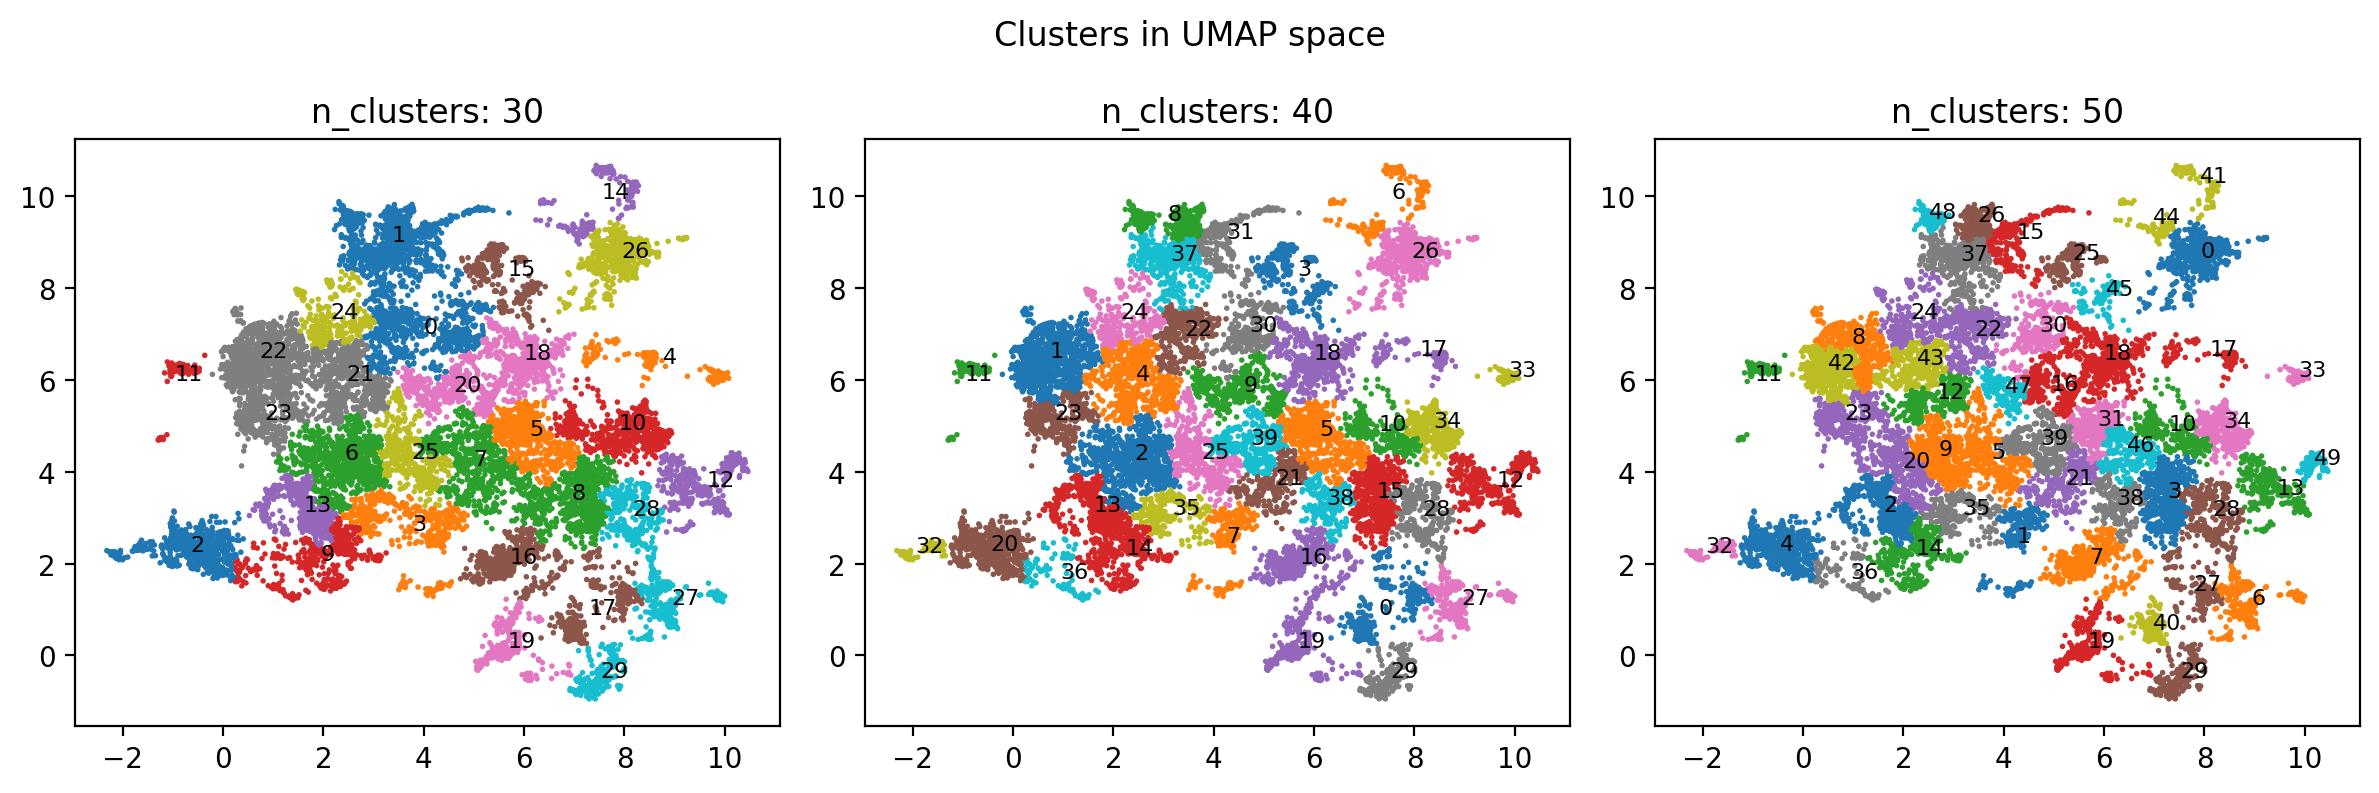

In [22]:
n_cluster_values = [30, 40, 50]

# plt.figure(figsize=(4, 4), dpi=200)
# ax = plt.gca()
f, axs = plt.subplots(1, len(n_cluster_values), figsize=(4*len(n_cluster_values), 4), dpi=200)

clusterings = {}
for (i, n_clusters) in enumerate(n_cluster_values):
    ax = axs[i]

    # Cluster the UMAP embeddings using Ward clustering
    ward_umap = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(umap_emb)
    clusterings[n_clusters] = ward_umap.labels_

    # Visualize the clusters in 2D
    if len(umap_emb) > 20000:
        random_idxs = np.random.choice(len(umap_emb), size=20000, replace=False)
        ax.scatter(umap_emb[random_idxs,0], umap_emb[random_idxs,1], c=ward_umap.labels_[random_idxs], cmap='tab10', s=1)
    else:
        ax.scatter(umap_emb[:,0], umap_emb[:,1], c=ward_umap.labels_, cmap='tab10', s=1)
        
    ax.set_title(f'n_clusters: {n_clusters}')

    # Add small annotations of cluster numbers near the points
    for j in range(n_clusters):
        cluster_centers = np.mean(umap_emb[ward_umap.labels_ == j], axis=0)
        ax.text(cluster_centers[0], cluster_centers[1], str(j), fontsize=8)

plt.suptitle('Clusters in UMAP space')
plt.tight_layout()
plt.show()

In [26]:
lm_metadata_with_clusters['cluster'] = clusterings[40]

#### Use GPT-4 to name the clusters

In [28]:
print(sample_cluster_texts(lm_metadata_with_clusters, 'cluster', cluster=0, n_papers=15))

The World of an Octopus: How Reporting Bias Influences a Language
  Model's Perception of Color

  Recent work has raised concerns about the inherent limitations of text-only
pretraining. In this paper, we first demonstrate that reporting bias, the
tendency of people to not state the obvious, is one of the causes of this
limitation, and then investigate to what extent multimodal training can
mitigate this issue. To accomplish this, we 1) generate the Color Dataset
(CoDa), a dataset of human-perceived color distributions for 521 common
objects; 2) use CoDa to analyze and compare the color distribution found in
text, the distribution captured by language models, and a human's perception of
color; and 3) investigate the performance differences between text-only and
multimodal models on CoDa. Our results show that the distribution of colors
that a language model recovers correlates more strongly with the inaccurate
distribution found in text than with the ground-truth, supporting the claim

In [33]:
import json

cluster_count = 40
n_trials_per_cluster = 3
cluster_col = 'cluster'
n_papers = 15

initialization = """
You are a researcher in the field of natural language processing that is trying to understand the main research directions of published papers.
"""

prompt = """
I will provide the titles and abstracts for a cluster of NLP papers. 
You will provide a short title summarizing the entire set, using less than or equal to 6 words.
Be as specific as possible, while still accurately describing most papers in the cluster.
Do not use general words like "advance", "improve", or "enhance", or any forms of these words.
Don't say NLP, since most of these papers are about NLP.
"""

t0 = time.time()
fp = os.path.join(PROCESSED_DATA_DIR, 'cluster_names', f'GPT4-lm-papers-cluster-names-n{cluster_count}.txt')
cluster_names = {i : [] for i in range(cluster_count)}

for i in range(cluster_count):
    print(f'Cluster {i}')
    for trial in range(n_trials_per_cluster):
        response = openai.ChatCompletion.create(
            model='gpt-4',
            messages=[
                {'role': 'system', 'content': initialization},
                {'role': 'user', 'content': prompt},
                {'role': 'user', 'content': 'Example: \n\n Input: \n\n' + sample_cluster_texts(lm_metadata_with_clusters, cluster_col, cluster=0, n_papers=10) + 'Output: \n\n'},
                {'role': 'assistant', 'content': 'Bias & Social Applications'},
                {'role': 'user', 'content': 'Input:\n\n' + sample_cluster_texts(lm_metadata_with_clusters, cluster_col, i, n_papers=n_papers, random_seed=trial) + 'Output:\n\n'},
            ],
            temperature=0.5,
        )
        cluster_name = response['choices'][0]['message']['content'].strip()
        print(cluster_name)
        cluster_names[i].append(cluster_name)
    print()
    # Sleep for 30 seconds to avoid rate limit
    time.sleep(27)

with open(fp, 'w') as f:
    json.dump(cluster_names, f, indent=4)

In [35]:
lm_metadata_with_clusters.to_json(os.path.join(PROCESSED_DATA_DIR, f'lm_papers_metadata_clusters.json'), 
                                    orient='records', lines=True)

### Replace the cluster IDs with strings of topic names

In [20]:
metadata_with_clusters = pd.read_json(os.path.join(PROCESSED_DATA_DIR, 'cs_stat_metadata_clusters.json'), orient='records', lines=True,
                                         dtype={'id': str, 'cluster': str})
lm_metadata_with_clusters = pd.read_json(os.path.join(PROCESSED_DATA_DIR, 'lm_papers_metadata_clusters.json'), orient='records', lines=True,
                                         dtype={'id': str, 'cluster': str})

In [24]:
import json

with open(os.path.join('.', 'data-prep', 'cluster_names', 'revised-cs-stat-cluster-names-n100.txt')) as f:
    cs_stat_cluster_names = json.load(f)
with open(os.path.join('.', 'data-prep', 'cluster_names', 'revised-lm-papers-cluster-names-n40.txt')) as f:
    lm_cluster_names = json.load(f)

metadata_with_clusters['cluster'] = metadata_with_clusters['cluster'].map(cs_stat_cluster_names)
lm_metadata_with_clusters['cluster'] = lm_metadata_with_clusters['cluster'].map(lm_cluster_names)

In [46]:
# Save these updated dataframes to the same location
metadata_with_clusters.to_json(os.path.join(PROCESSED_DATA_DIR, f'cs_stat_metadata_clusters.json'), 
                                    orient='records', lines=True)
lm_metadata_with_clusters.to_json(os.path.join(PROCESSED_DATA_DIR, f'lm_papers_metadata_clusters.json'),
                                    orient='records', lines=True)

### Rename a few clusters

In [10]:
lm_metadata_with_clusters = pd.read_json(os.path.join(PROCESSED_DATA_DIR, 'lm_papers_metadata_clusters.json'), orient='records', lines=True,
                                         dtype={'id': str, 'cluster': str})

In [14]:
renaming_dict = {
    # 'Social Bias & Harms': 'Biases & Harms',
    # 'LMs for Science': 'Natural Sciences',
    'Applications of ChatGPT': 'Applications of LLMs/ChatGPT',
    'Reasoning & Understanding in LMs': 'Interpretability & Reasoning',
}

# All other clusters stay the same
for cluster_name in lm_metadata_with_clusters['cluster'].unique():
    if cluster_name not in renaming_dict:
        renaming_dict[cluster_name] = cluster_name

lm_metadata_with_clusters['cluster'] = lm_metadata_with_clusters['cluster'].map(renaming_dict)
lm_metadata_with_clusters

,id,authors,title,categories,abstract,versions,first_category,v1_date,LM_related_terms,mentions_LM_keyword,emails,cluster
0,1801.00409,"[Haris Bin Zia, Agha Ali Raza, Awais Athar]",PronouncUR: An Urdu Pronunciation Lexicon Gene...,[cs.CL],State-of-the-art speech recognition systems ...,"[{'version': 'v1', 'created': 'Mon, 1 Jan 2018...",cs.CL,1514793249000,[language model],True,"[{haris.zia, agha.ali.raza}@itu.edu.pk, awais@...",Speech Recognition
1,1801.00841,"[Kanishka Rao, Haşim Sak, Rohit Prabhavalkar]","Exploring Architectures, Data and Units For St...","[cs.CL, cs.SD, eess.AS]",We investigate training end-to-end speech re...,"[{'version': 'v1', 'created': 'Tue, 2 Jan 2018...",cs.CL,1514928581000,[language model],True,"[{kanishkarao,hasim,prabhavalkar}@google.com]",Speech Recognition
2,1801.03844,"[Jibril Frej, Jean-Pierre Chevallet, Didier Sc...",Enhancing Translation Language Models with Wor...,[cs.IR],"In this paper, we explore the usage of Word ...","[{'version': 'v1', 'created': 'Thu, 11 Jan 201...",cs.IR,1515686907000,[language model],True,"[jibril.frej@etu.univ-grenoble-alpes.fr, jean-...","Representations, Syntax, Semantics"
3,1801.06146,"[Jeremy Howard, Sebastian Ruder]",Universal Language Model Fine-tuning for Text ...,"[cs.CL, cs.LG, stat.ML]",Inductive transfer learning has greatly impa...,"[{'version': 'v1', 'created': 'Thu, 18 Jan 201...",cs.CL,1516298092000,[language model],True,"[sebastian@ruder.io, j@fast.ai]",Pretrained LMs & Text Classification
4,1801.06271,"[Mario Linares-Vasquez, Martin White, Carlos B...",Mining Android App Usages for Generating Actio...,[cs.SE],GUI-based models extracted from Android app ...,"[{'version': 'v1', 'created': 'Fri, 19 Jan 201...",cs.SE,1516328517000,[language model],True,"[{mlinarev, mgwhite, cebernal, kpmoran, denys}...","Software, Planning, Robotics"
...,...,...,...,...,...,...,...,...,...,...,...,...
16974,2309.03882,"[Chujie Zheng, Hao Zhou, Fandong Meng, Jie Zho...",On Large Language Models' Selection Bias in Mu...,[cs.CL],Multi-choice questions (MCQs) serve as a com...,"[{'version': 'v1', 'created': 'Thu, 7 Sep 2023...",cs.CL,1694108696000,"[language model, large language model]",True,"[chujiezhengchn@gmail.com, aihuang@tsinghua.ed...",Biases & Harms
16975,2309.03883,"[Yung-Sung Chuang, Yujia Xie, Hongyin Luo, Yoo...",DoLa: Decoding by Contrasting Layers Improves ...,"[cs.CL, cs.AI, cs.LG]","Despite their impressive capabilities, large...","[{'version': 'v1', 'created': 'Thu, 7 Sep 2023...",cs.CL,1694108731000,"[language model, large language model, LLaMA]",True,"[yungsung@mit.edu, yujiaxie@microsoft.com, {hy...",Applications and Benchmark Evaluations
16976,2309.03884,"[Tal Shaharabany, Ariel Shaulov, Lior Wolf]",Zero-Shot Audio Captioning via Audibility Guid...,"[cs.SD, cs.CL, eess.AS]",The task of audio captioning is similar in e...,"[{'version': 'v1', 'created': 'Thu, 7 Sep 2023...",cs.SD,1694108758000,"[language model, large language model, GPT-2, ...",True,[],Audio and Music Modeling
16977,2309.03886,"[Sarah Schwettmann, Tamar Rott Shaham, Joanna ...",A Function Interpretation Benchmark for Evalua...,"[cs.CL, cs.AI, cs.LG]",Labeling neural network submodules with huma...,"[{'version': 'v1', 'created': 'Thu, 7 Sep 2023...",cs.CL,1694108846000,[language model],True,"[schwett@mit.edu, tamarott@mit.edu]",Knowledge Graphs and Commonsense


In [16]:
lm_metadata_with_clusters.to_json(os.path.join(PROCESSED_DATA_DIR, f'lm_papers_metadata_clusters.json'),
                                    orient='records', lines=True)

### For manual-verification of topic names

In [51]:
# Print some papers from each cluster of metadata

for cluster in range(100):
    print(f'Cluster {cluster}')
    print(sample_cluster_texts(metadata_with_clusters, 'cluster', cluster=cluster, n_papers=10, titles_only=True))
    print()

Cluster 0
Completeness for Game Logic

Provable Fictitious Play for General Mean-Field Games

Limit Cycles Analysis and Control of Evolutionary Game Dynamics with
  Environmental Feedback

Optimal Pure Strategies for a Discrete Search Game

Physical Zero-Knowledge Proof for Numberlink Puzzle and $k$
  Vertex-Disjoint Paths Problem

Edge colouring Game on Trees with maximum degree $\Delta=4$

Mission Level Uncertainty in Multi-Agent Resource Allocation

On the Role of Hypocrisy in Escaping the Tragedy of the Commons

Rikudo is NP-complete

Learning Minimax Estimators via Online Learning

Cluster 1
Multi-Layer Modeling of Dense Vegetation from Aerial LiDAR Scans

The Platform for non-metallic pipes defects recognition. Design and
  Implementation

SiamixFormer: a fully-transformer Siamese network with temporal Fusion
  for accurate building detection and change detection in bi-temporal remote
  sensing images

Towards Adaptive Benthic Habitat Mapping

An Efficient and Small Convolutional

In [7]:
# Print some papers from each cluster of lm_metadata_with_clusters

for cluster in range(40):
    print(f'Cluster {cluster}')
    print(sample_cluster_texts(lm_metadata_with_clusters, 'cluster', cluster=cluster, n_papers=40,
                                random_seed=6,
                                titles_only=True))
    print()

Cluster 0
Using Natural Sentences for Understanding Biases in Language Models

The Unequal Opportunities of Large Language Models: Revealing
  Demographic Bias through Job Recommendations

LESA: Linguistic Encapsulation and Semantic Amalgamation Based
  Generalised Claim Detection from Online Content

Same Side Stance Classification Task: Facilitating Argument Stance
  Classification by Fine-tuning a BERT Model

Annotating the Tweebank Corpus on Named Entity Recognition and Building
  NLP Models for Social Media Analysis

AI Chat Assistants can Improve Conversations about Divisive Topics

Selection Bias Induced Spurious Correlations in Large Language Models

How Different Is Stereotypical Bias Across Languages?

On the Limitations of Sociodemographic Adaptation with Transformers

Fair and Argumentative Language Modeling for Computational Argumentation

The Myth of Culturally Agnostic AI Models

AI-Augmented Surveys: Leveraging Large Language Models for Opinion
  Prediction in Nationall